# Storypoint Prediction: Problem Exploration

## Problem Statement

In modern agile development settings, software is developed through repeated cycles (iterative) and in smaller parts at a time (incremental), allowing for adaptation to changing requirements at any point during a project’s life. A project has a number of iterations (e.g. sprints in Scrum). Each iteration requires the completion of a number of user stories, which are a common way for agile teams to express user requirements. 

There is thus a need to focus on estimating the effort of completing a single user story at a time rather than the entire project. In fact, it has now become a common practice for agile teams to go through each user story and estimate its “size”. Story points are commonly used as a unit of measure for specifying the overall size of a user story.


## Problem Formulation

**Input:** A string of length *N* that contains a story's name and description $C=\{c_1, c_2, c_3,..., c_n\}$. For each story, a set of text embeddings that contains features $E=\{e_1, e_2, e_3,...,e_m\}$ extracted from C has been provided.

**Output**: A natural number P associated with the story point of that user story

## Dataset Information

**Text Embeddings:** Text embeddings are a way to convert words or phrases from text into a list of numbers, where each number captures a part of the text's meaning. The dataset has been preprocessed and converted into two kinds of text embeddings. You can choose to work with either of them or both:
- Doc2Vec: Input strings are transformed into fixed-length vectors of size 128. These vectors capture the semantic meaning of words and their relationships within a document.
- Look-upTable: Input strings are transformed into fixed-length vectors of size 2264. These vectors are obtained via transforming each word in the input strings into an identifier number, then padded to the length of the longest sample.


**Dataset Structure & Format:** Storypoint Estimation Dataset is stored in 3 folders labeled *raw data*, *look-up*, and *doc2vec*. Within each folder are 3 CSV files for training, testing, validation. Each csv file has the following columns:
-	`issuekey` : The unique identifier for a story.
-	`storypoint`: The correct number of storypoint.
-	An embedding column (`embedding` or  `doc2vec`) contains text embedding vectors. The raw data csv will not have this and instead contain two columns with story `name` and `description`.


## Exploration

### Raw data exploration

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

#### Output exploration

In [15]:
# Import raw data from the CSV file

project_name = 'bamboo'

all_data = pd.concat([pd.read_csv('data/' + project_name + '/' + project_name + '_train.csv'), 
                      pd.read_csv('data/' + project_name + '/' + project_name + '_valid.csv'),
                      pd.read_csv('data/' + project_name + '/' + project_name + '_test.csv')])

print('Check the shape of the dataset', all_data.shape)


Check the shape of the dataset (374, 4)


In [16]:
all_data.drop(['issuekey'], axis=1, inplace=True)
all_data.head()

,title,description,storypoint
0,allows cvs repo timeout report locking issues,sometimes perform cvs action get something lik...,3
1,result saved checkout fails,happened yesterday hosted bamboo bamboo upgrad...,2
2,talkback elastic agent bamboo server include e...,elastic instanceagent configured mount ebs vol...,2
3,users see maven module groupid artifactid vers...,respect subworking directory look poms subwork...,5
4,postbuildprocessor plugin kick maven pomxml pa...,consider running remote agents functional test...,2


First, let take a look at the distribution of the story point:

Interpretation of Skewness Values:

- **Skewness > 0**: Right-skewed distribution.
- **Skewness < 0**: Left-skewed distribution.
- **Skewness = 0**: Symmetrical distribution (like a normal distribution).

Interpretaion of kurtosis:
- **Leptokurtic (Kurtosis > 3)**: The distribution has heavier tails and a sharper peak than the normal distribution. Data points are more likely to produce extreme values. The distribution has a higher peak and fatter tails.
- **Platykurtic (Kurtosis < 3)**: The distribution has lighter tails and a flatter peak than the normal distribution. Data are fewer extreme values compared to a normal distribution.
- **Mesokurtic (Kurtosis ≈ 3)**: The distribution has a similar kurtosis to the normal distribution, indicating a moderate level of outliers.

Skewness: 4.054075020469427
Kurtosis: 25.929995905726138


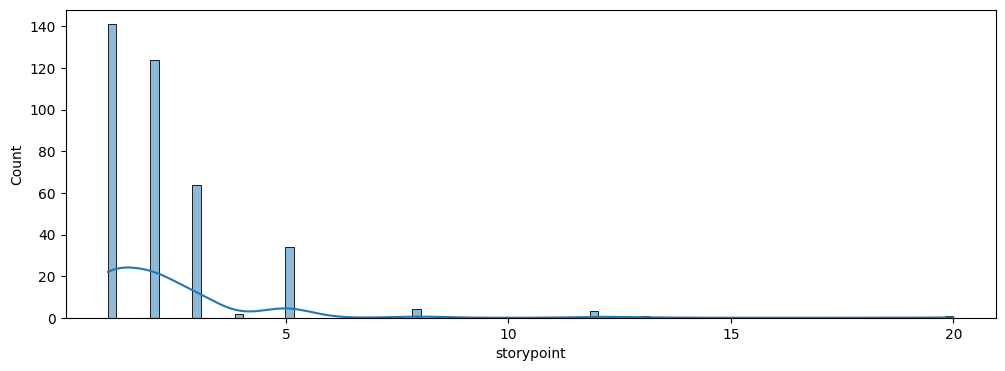

In [17]:
# Draw a histogram of the story points
plt.figure(figsize=(12, 4))
plt.xticks(np.arange(0, max(all_data['storypoint']) + 1, 5))
sns.histplot(all_data['storypoint'], bins=100, kde=True)

print('Skewness:', all_data['storypoint'].skew())
print('Kurtosis:', all_data['storypoint'].kurt())

In [18]:
tmp = pd.concat([all_data['storypoint'].value_counts(), 
                 all_data['storypoint'].value_counts() / all_data.shape[0] * 100],
                axis=1, keys=['Counts', 'Percentage (%)'])
tmp.head(20)

,Counts,Percentage (%)
storypoint,,
1,141,37.700535
2,124,33.155080
3,64,17.112299
5,34,9.090909
8,4,1.069519
12,3,0.802139
4,2,0.534759
20,1,0.267380
13,1,0.267380


At the first sight, this data is bad. Then take a look at the statistic values, this data is even worse. Its distribution of the label is **right-skewed** and **leptokurtis**. This means if we use this to train model, the right side of the data can be the outliers and make the models become unsuable.

I will try 2 solutions:
- Use log-scale on the label
- Remove all the examples with label greater than a threshold (20, 30 or 40)

The first solution: logarithm magic

<Axes: xlabel='storypoint', ylabel='Count'>

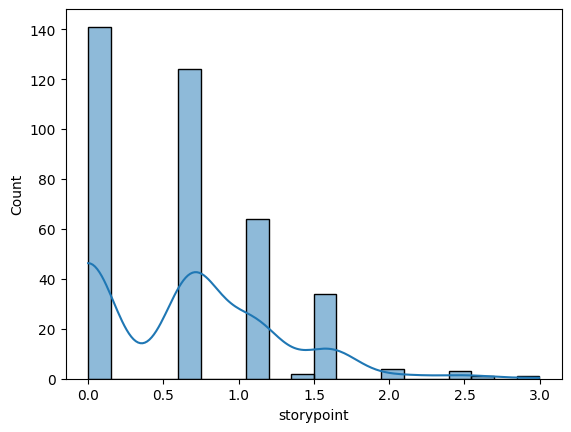

In [19]:
sns.histplot(np.log(all_data['storypoint']), bins=20, kde=True)

The second solution: Dismantle and Cleave

Fitered percentage:  1.0 %


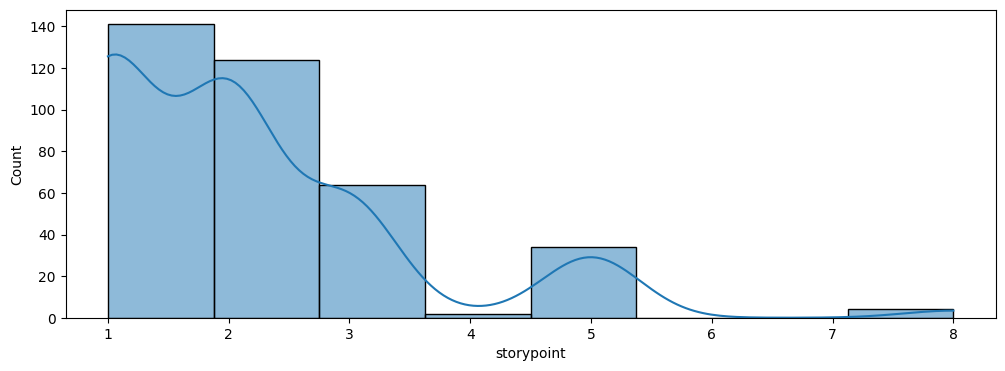

In [24]:
threshold = 8 # This threshold means that we will take all the examples with story points less than or equal to 8

new_data = all_data[all_data['storypoint'] <= threshold]
plt.figure(figsize=(12, 4))
plt.xticks(np.arange(0, max(new_data['storypoint']) + 1, 1))
sns.histplot(new_data['storypoint'], bins=threshold, kde=True)
print('Fitered percentage: ', round(1 - new_data.shape[0] / all_data.shape[0], 2) * 100, '%')

#### Input exploration

The input of this problem is 2 texts: title and description. First we will find some statistics:

In [25]:
title_lengths = all_data['title'].apply(lambda x: len(x.split(' ')))
print('Title analysis:')
print('   - Mean length:', round(title_lengths.mean()))
print('   - Min length:', title_lengths.min())
print('   - Max length:', title_lengths.max())

description_lengths = all_data['description'].apply(lambda x: len(x.split(' ')) if type(x) != float else 0)
print('Description analysis:')
print('   - Mean length:', round(description_lengths.mean()))
print('   - Min length:', description_lengths.min())
print('   - Max length:', description_lengths.max())

Title analysis:
   - Mean length: 6
   - Min length: 2
   - Max length: 17
Description analysis:
   - Mean length: 44
   - Min length: 0
   - Max length: 982


Plot the histogram of the title length and KDE of the description length (exclude 0):

<Axes: xlabel='Description Length', ylabel='Density'>

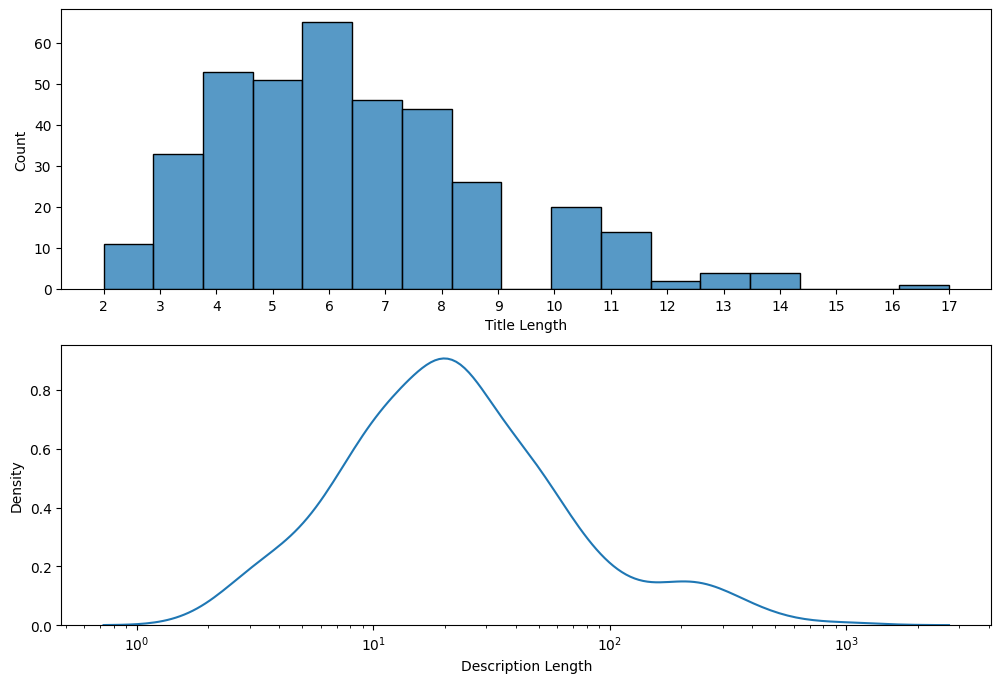

In [27]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.xticks(np.arange(0, max(title_lengths) + 1, 1))
plt.xlabel('Title Length')
sns.histplot(title_lengths, bins=max(title_lengths))

plt.subplot(2, 1, 2)
plt.xlabel('Description Length')
plt.xscale('log')
sns.kdeplot(description_lengths[description_lengths > 0])

I think we should check the correlation between title length and description length:

<Axes: xlabel='description', ylabel='storypoint'>

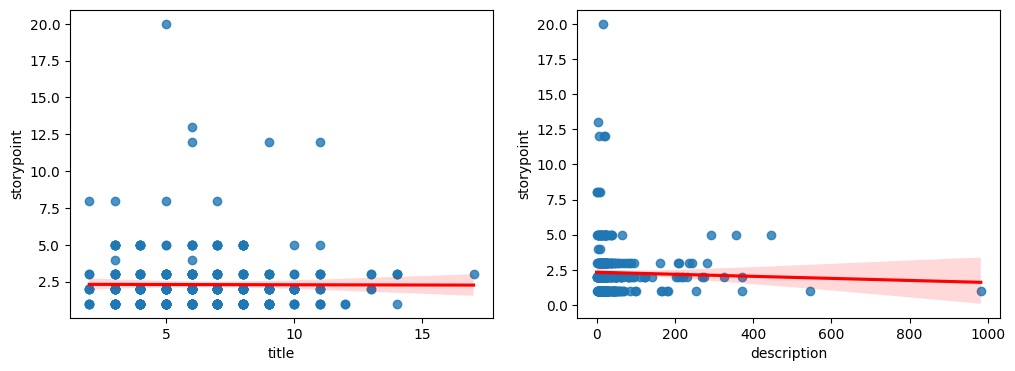

In [28]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.xticks(np.arange(0, max(all_data['title'].apply(lambda x: len(x.split(' ')))) + 1, 5))
sns.regplot(x=all_data['title'].apply(lambda x : len(x.split(' '))), 
            y=all_data['storypoint'], 
            line_kws={'color': 'red'})

plt.subplot(1, 2, 2)
sns.regplot(x=all_data['description'].apply(lambda x : len(x.split(' ')) if type(x) != float else 0), 
            y=all_data['storypoint'], 
            line_kws={'color': 'red'})

Maybe a little bit relation in decription

Let dive deeper in the input:

Title analysis:

In [29]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(all_data['title'])

dictionary = pd.DataFrame(list(count_vectorizer.vocabulary_.items()), columns=['word', 'frequency'])
dictionary.sort_values(by='frequency', ascending=False, inplace=True)
print(dictionary.shape)
dictionary.head(10)

(983, 2)


,word,frequency
146,zones,982
400,youve,981
707,xwork,980
966,xml,979
507,wrong,978
484,written,977
68,world,976
618,works,975
270,working,974
617,workflow,973


Description analysis:

In [30]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(all_data[all_data['description'].isnull() == False]['description'])

dictionary = pd.DataFrame(list(count_vectorizer.vocabulary_.items()), columns=['word', 'frequency'])
dictionary.sort_values(by='frequency', ascending=False, inplace=True)
print(dictionary.shape)
dictionary.head(20)

(3985, 2)


,word,frequency
1823,zones,3984
749,zone,3983
3856,zip,3982
1258,zero,3981
3485,zed,3980
3603,yyyjob,3979
3544,yyy,3978
415,yumnoarch,3977
501,yumfastestmirrornoarch,3976
366,yum,3975


Yet I don't find any thing special about the words in input except so many things are bad.

### Solving strategies

My first intuitation in this problem is that the hard part is not on the algorithm we use, it is on the **embedding** part. Therefore, in case the given embedded datasets work not properly, I will use a better embedding method which is **Bidirectional Encoder Representations from Transformers (BERT)**. Also, I will try an old way to embedding the text too: **Bag of words**.

In conclusion, I will have 4 ways to embed the text:
- doc2vec (already available)
- Look up (already available)
- Bag Of Words
- BERT

About algorithm, I will try all the regression algorithm that may give a good result:

- Ridge Regressor
- Support Vector Regressor
- Random Forest Regressor
- Gradient Boosting
- XGBoost
- Lightgbm
- Blended

Maybe, we can change the problem to the classification problem with 100 labels (desparation confirmed). In the classification problem, I will use:
- Support Vector Classifier
- Softmax Regression (Multinomial Logistic Regression)
- Random Forest
- Adaboost
- XGBoost


Thanks to the libaries, the implementation of all the algorithm shrinks to its minimum form.

At last, there is still a situation that all of mentioned model don't give a good result. This gamble is thrilling (hopeless).

*"But would you lose?"*

Nah, I'd win.